In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score



In [123]:
df = pd.read_csv('../resources/linux/log-structured/Linux.log_sequences.csv')

In [124]:
X = df.iloc[:, 1:-1].values
y = df["Severity"].values
print(X.shape, y.shape)

(225, 106) (225,)


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [127]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [128]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # one output neuron

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # logistic (sigmoid) activation

model = LogisticRegressionModel(input_dim=X_train.shape[1])


In [129]:
criterion = nn.BCELoss()  # binary cross-entropy
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [130]:
num_epochs = 50

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [131]:
with torch.no_grad():  # disables gradient computation
    y_pred_probs = model(X_test)            # predicted probabilities, shape [N,1]
    y_pred = (y_pred_probs > 0.5).float()   # convert probabilities to 0/1 labels


In [132]:
y_pred_np = y_pred.numpy().flatten()  # flatten to 1D
y_test_np = y_test.numpy().flatten()

print("Predicted labels:", y_pred_np)

accuracy = accuracy_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1:.2f}")


Predicted labels: [1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
Accuracy: 88.89%
Recall: 100.00%
F1 Score: 0.88


In [133]:
coefficients = model.linear.weight.detach().numpy().flatten()
event_names = list(df.columns)[1:-1] # if hasattr(X_train, 'columns') else [f"E{i+1}" for i in range(len(coefficients))]

feature_importance = pd.DataFrame({
    "EventId": event_names,
    "Coefficient": coefficients
})

# Sort by absolute value
feature_importance["Importance"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))

   EventId  Coefficient  Importance
63     E64    -0.561239    0.561239
81     E82     0.434117    0.434117
74     E75    -0.375580    0.375580
2       E3    -0.349016    0.349016
28     E29    -0.332921    0.332921
19     E20    -0.307163    0.307163
73     E74    -0.298252    0.298252
53     E54    -0.188010    0.188010
31     E32    -0.154862    0.154862
87     E88    -0.144560    0.144560


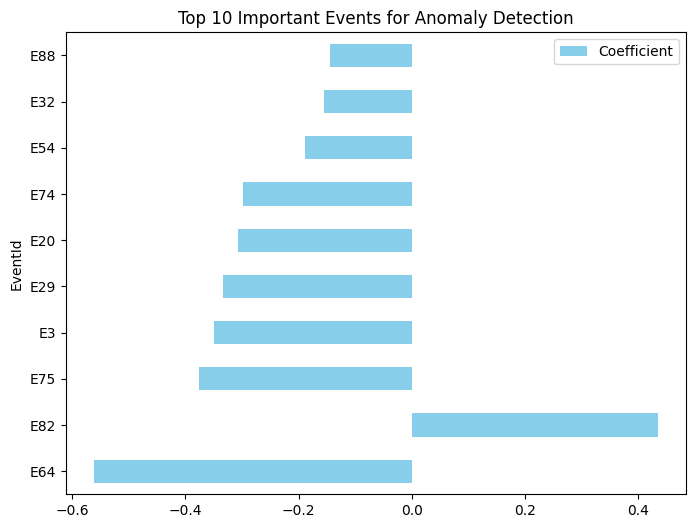

In [134]:
import matplotlib.pyplot as plt

feature_importance.head(10).plot(
    x="EventId", y="Coefficient", kind="barh", figsize=(8,6), color="skyblue"
)
plt.title("Top 10 Important Events for Anomaly Detection")
plt.show()
